# Implementing Decision Trees

In [3]:
import numpy as np
import pandas as pd
import random 
import matplotlib.pyplot as plt
from IPython.display import Image
from sklearn.datasets import make_moons
from pprint import pprint
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree
from sklearn.tree import plot_tree

In [4]:
#Checking purity of the data
#It checks if there are more than 1 labels. There should be in the beginning to make a decision tree but as we grow the tree
#the nodes and leaves would become more pure
def check_purity(data):
    
    label_column = data[:, -1]
    unique_classes = np.unique(label_column)

    if len(unique_classes) == 1:
        return True
    else:
        return False

In [5]:
#this function checks if we are creating a regression or a classification tree and creates a leaf based on the task
#where the leaf node is decided by the mean on the values in the predictor column in case of regression and by majority rule
#in case of classification
def create_leaf(data, ml_task):
    
    label_column = data[:, -1]
    if ml_task == "regression":
        leaf = np.mean(label_column)
        
    # classfication    
    else:
        unique_classes, counts_unique_classes = np.unique(label_column, return_counts=True)
        index = counts_unique_classes.argmax()
        leaf = unique_classes[index]
    
    return leaf

In [6]:
# to decide where to split the data we make a function which takes the input as the dataframe and see how many unique values
#are there in those dependent variables. (Need to check its exact working)
def get_potential_splits(data):
    
    potential_splits = {}
    _, n_columns = data.shape
    for column_index in range(n_columns - 1): # excluding the last column which is the label
        values = data[:, column_index]
        unique_values = np.unique(values)
        
        potential_splits[column_index] = unique_values
    
    return potential_splits

In [7]:
#function to calculate entropy for classification case
def calculate_entropy(data):
    
    label_column = data[:, -1]
    _, counts = np.unique(label_column, return_counts=True)

    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))
     
    return entropy

In [8]:
#function to calculate MSE for regression case
def calculate_mse(data):
    actual_values = data[:, -1]
    if len(actual_values) == 0:   # empty data
        mse = 0
        
    else:
        prediction = np.mean(actual_values)
        mse = np.mean((actual_values - prediction) **2)
    
    return mse

In [9]:
#see how many points are data points are above and below the best split for the leaf. The metric is dependent on the ml task
def calculate_overall_metric(data_below, data_above, metric_function):
    
    n = len(data_below) + len(data_above)
    p_data_below = len(data_below) / n
    p_data_above = len(data_above) / n

    overall_metric =  (p_data_below * metric_function(data_below) 
                     + p_data_above * metric_function(data_above))
    
    return overall_metric

In [10]:
#decides the best splitting point for the ml task. if regression -> based on lowest MSE
#if classification -> based on entropy
def determine_best_split(data, potential_splits, ml_task):
    
    first_iteration = True
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below, data_above = split_data(data, split_column=column_index, split_value=value)
            
            if ml_task == "regression":
                current_overall_metric = calculate_overall_metric(data_below, data_above, metric_function=calculate_mse)
            
            # classification
            elif ml_task == "classification":
                current_overall_metric = calculate_overall_metric(data_below, data_above, metric_function=calculate_entropy)

            if first_iteration or current_overall_metric <= best_overall_metric:
                first_iteration = False
                
                best_overall_metric = current_overall_metric
                best_split_column = column_index
                best_split_value = value
    
    return best_split_column, best_split_value

In [11]:
#splits the data based on the values of the column from the above function
def split_data(data, split_column, split_value):
    
    split_column_values = data[:, split_column]

    type_of_feature = FEATURE_TYPES[split_column]
    if type_of_feature == "continuous":
        data_below = data[split_column_values <= split_value]
        data_above = data[split_column_values >  split_value]
    
    # feature is categorical   
    else:
        data_below = data[split_column_values == split_value]
        data_above = data[split_column_values != split_value]
    
    return data_below, data_above

In [12]:
#helper functions for the decision tree
#checks if the functions are categorical or numerical

def determine_type_of_feature(df):
    
    feature_types = []
    n_unique_values_treshold = 15
    for feature in df.columns:
        if feature != "label":
            unique_values = df[feature].unique()
            example_value = unique_values[0]

            if (isinstance(example_value, str)) or (len(unique_values) <= n_unique_values_treshold):
                feature_types.append("categorical")
            else:
                feature_types.append("continuous")
    
    return feature_types

In [13]:
#final decision tree algorithm that takes as input: dataframe, the type of algorithm, and the hyperparamters
def decision_tree_algorithm(df, ml_task, counter=0, min_samples=2, max_depth=5):
    
    # data preparations
    if counter == 0:
        global COLUMN_HEADERS, FEATURE_TYPES
        COLUMN_HEADERS = df.columns
        FEATURE_TYPES = determine_type_of_feature(df)
        data = df.values
    else:
        data = df           
    
    
    # base cases
    if (check_purity(data)) or (len(data) < min_samples) or (counter == max_depth):
        leaf = create_leaf(data, ml_task)
        return leaf

    
    # recursive part
    else:    
        counter += 1

        # helper functions 
        potential_splits = get_potential_splits(data)
        split_column, split_value = determine_best_split(data, potential_splits, ml_task)
        data_below, data_above = split_data(data, split_column, split_value)
        
        # check for empty data
        if len(data_below) == 0 or len(data_above) == 0:
            leaf = create_leaf(data, ml_task)
            return leaf
        
        # determine question
        feature_name = COLUMN_HEADERS[split_column]
        type_of_feature = FEATURE_TYPES[split_column]
        if type_of_feature == "continuous":
            question = "{} <= {}".format(feature_name, split_value)
            
        # feature is categorical
        else:
            question = "{} = {}".format(feature_name, split_value)
        
        # instantiate sub-tree
        sub_tree = {question: []}
        
        # find answers (recursion)
        yes_answer = decision_tree_algorithm(data_below, ml_task, counter, min_samples, max_depth)
        no_answer = decision_tree_algorithm(data_above, ml_task, counter, min_samples, max_depth)
        
        # If the answers are the same, then there is no point in asking the qestion.
        # This could happen when the data is classified even though it is not pure
        # yet (min_samples or max_depth base case).
        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)
        
        return sub_tree


# Predictions

In [14]:
def predict_example(example, tree):
    
    # tree is just a root node
    if not isinstance(tree, dict):
        return tree
    
    question = list(tree.keys())[0]
    feature_name, comparison_operator, value = question.split(" ")

    # ask question
    if comparison_operator == "<=":
        if example[feature_name] <= float(value):
            answer = tree[question][0]
        else:
            answer = tree[question][1]
    
    # feature is categorical
    else:
        if str(example[feature_name]) == value:
            answer = tree[question][0]
        else:
            answer = tree[question][1]

    # base case
    if not isinstance(answer, dict):
        return answer
    
    # recursive part
    else:
        residual_tree = answer
        return predict_example(example, residual_tree)

In [15]:
def make_predictions(df, tree):
    
    if len(df) != 0:
        predictions = df.apply(predict_example, args=(tree,), axis=1)
    else:
        # "df.apply()"" with empty dataframe returns an empty dataframe,
        # but "predictions" should be a series instead
        predictions = pd.Series()
        
    return predictions

In [16]:
def calculate_accuracy(df, tree):
    predictions = make_predictions(df, tree)
    predictions_correct = predictions == df.label
    accuracy = predictions_correct.mean()
    
    return accuracy

# Testing on Classification Data - Make Moons

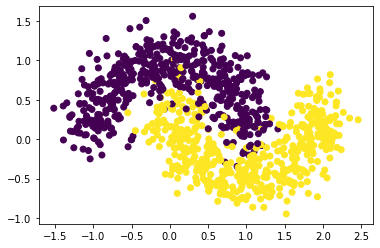

In [17]:
#loading and checking the moons data
N = 1000
X,Y = make_moons(N,noise=0.2)
plt.scatter(X[:,0],X[:,1], c=Y)
plt.show()

In [18]:
#converting the dataset into a dataframe and combinning the independent and dependent variables
X = pd.DataFrame(X)
Y = pd.DataFrame(Y)
X = X.rename(columns={X.columns[0]: 'X1'})
X = X.rename(columns={X.columns[1]: 'X2'})
Y = Y.rename(columns={Y.columns[0]: 'label'})
data = pd.concat([X, Y], axis=1)
data = pd.DataFrame(data)
type(data)

pandas.core.frame.DataFrame

In [19]:
data.isnull().sum(axis = 0)

X1       0
X2       0
label    0
dtype: int64

In [20]:
#function for making the train and test split
'''
takes the dataframe as input and splits the data into train and test based on the train size.

'''

def train_test_split(df,train_size):
    train_size = train_size
    train_end = int(len(df)*train_size)

    train = df[:train_end]
    test = df[train_end:]
    
    return train, test

In [21]:
random.seed(0)
train_df, test_df = train_test_split(data, train_size=0.7)

In [22]:
tree = decision_tree_algorithm(train_df,ml_task = "classification", max_depth=5)
accuracy = calculate_accuracy(test_df, tree)

In [23]:
accuracy

0.9533333333333334

In [24]:
pprint(tree, width=50)

{'X2 <= 0.13329408660973352': [{'X1 <= -0.4821445156076398': [0.0,
                                                              1.0]},
                               {'X1 <= 1.304194516669945': [{'X2 <= 0.5902104958324692': [{'X1 <= -0.2652859855934563': [0.0,
                                                                                                                         {'X1 <= 0.4196478687267429': [1.0,
                                                                                                                                                       0.0]}]},
                                                                                          {'X1 <= -0.19280270073675487': [0.0,
                                                                                                                          {'X1 <= -0.1895238588574085': [1.0,
                                                                                                                                         

In [25]:
train_df.column

AttributeError: 'DataFrame' object has no attribute 'column'

# Plotting the tree

In [26]:
fig = plt.figure(figsize=(25,20))
dec_tree = plot_tree(decision_tree=tree, feature_names = train_df_x, 
                     class_names =train_df_y.values , filled = True , precision = 4, rounded = True)

NameError: name 'train_df_x' is not defined

<Figure size 1800x1440 with 0 Axes>

# Testing on Regression Data

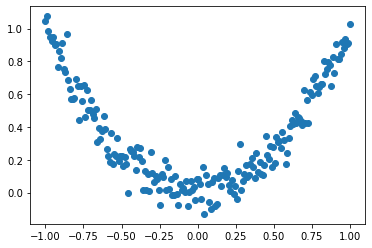

In [30]:
N = 200
X = np.linspace(-1,1,N)
Y = X**2+ np.random.normal(0,0.07,N)
X = X.reshape(-1,1)
plt.scatter(X,Y)
plt.show()

In [33]:
X = pd.DataFrame(X)
Y = pd.DataFrame(Y)

In [36]:
X = X.rename(columns={X.columns[0]: 'X'})
Y = Y.rename(columns={Y.columns[0]: 'label'})
data_reg = pd.concat([X, Y], axis=1)
data_reg = pd.DataFrame(data_reg)
data_reg.head()

,X,label
0,-1.000000,1.046239
1,-0.989950,1.074955
2,-0.979899,0.984634
3,-0.969849,0.947431
4,-0.959799,0.923079


In [37]:
random.seed(0)
train_df, test_df = train_test_split(data_reg, train_size=0.7)

In [38]:
tree = decision_tree_algorithm(train_df,ml_task = "regression", max_depth=15)
accuracy = calculate_accuracy(test_df, tree)

In [39]:
accuracy


0.0